In [17]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import time

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [18]:
# load recession data
recession = pd.read_csv('recession.csv', index_col = 0, parse_dates=True)
print(f'Number of Recession months: ', recession[recession.Regime == 1.0].shape[0])
print(f'Number of Expansion months: ', recession[recession.Regime == 0.0].shape[0])
recession.head()

Number of Recession months:  579
Number of Expansion months:  1450


,Regime
Date,
1854-12-01,1.0
1855-01-01,0.0
1855-02-01,0.0
1855-03-01,0.0
1855-04-01,0.0


In [19]:
# load S&P500
sp = pd.read_csv('sp500.csv', index_col = 0, parse_dates=True)

# resample daily prices to monthly prices
sp = sp.resample('MS').first()
sp

,S&P500
Date,
1928-01-01,17.57
1928-02-01,17.26
1928-03-01,19.28
1928-04-01,19.75
1928-05-01,20.00
...,...
2023-08-01,4507.66
2023-09-01,4288.05
2023-10-01,4193.80


In [20]:
# load dataset
df = pd.read_csv('dataset.csv', index_col=0, parse_dates=True) #.reset_index(names='Date')
df

,RPI,W875RX1,DSPIC96,PIROA,PSAVERT,DPCERA3M086SBEA,UMCSENT,PCE,W055RC1,RETAIL,...,PPIIDC,WTISPLC,IPMINE,M1109BUSM293NNBR,CCUSSP01GBM650N,CCUSSP01JPM650N,CCUSSP01DEM650N,CCUSSP01CAM650N,CCUSSP01MXM650N,CCUSSP02CNM650N
1959-01-01,2583.560,2426.0,2318.4,38.4,11.3,15.188,NaN,306.1,40.2,17583.0,...,30.300,3.00,62.6418,592.29,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,2593.596,2434.8,2325.4,38.9,10.6,15.346,NaN,309.6,40.8,17712.0,...,30.400,3.00,63.0540,590.72,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,2610.396,2452.7,2338.7,39.2,10.3,15.491,NaN,312.7,41.3,17860.0,...,30.500,2.97,63.1913,609.12,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,2627.446,2470.0,2353.8,39.7,11.2,15.435,NaN,312.2,41.7,17871.0,...,30.500,2.97,65.0459,616.99,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,2642.720,2486.4,2366.6,40.1,10.6,15.622,95.3,316.1,42.1,18011.0,...,30.500,2.97,66.4883,630.80,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,19084.305,15680.1,16808.4,3594.4,4.4,116.235,71.5,18595.4,2739.7,NaN,...,254.313,76.07,120.0011,NaN,1.28655,0.007096,1.1023,0.758898,5.975929,7.1473
2023-08-01,19098.603,15707.7,16814.6,3607.3,4.4,116.171,69.4,18651.6,2759.4,NaN,...,259.338,81.39,119.1503,NaN,1.26800,0.006846,1.0868,0.739044,5.938172,7.2899
2023-09-01,19088.877,15719.1,16804.5,3617.9,3.8,116.594,67.9,18791.5,2770.3,NaN,...,260.832,89.43,120.2024,NaN,1.22675,0.006692,1.0594,0.739645,5.640572,7.3037
2023-10-01,19131.126,15767.9,16848.4,3645.7,4.0,116.682,63.8,18812.2,2769.3,NaN,...,256.777,85.64,118.8468,NaN,1.21775,0.006691,1.0619,0.720929,5.532442,7.3182


# Visualize Recession Periods

In [21]:
def get_recession_periods(df):
  '''
  Returns the first and last months of the recessionary period.
  ----------
  Parameters
  ----------
  df : data frame with stock price and regime indicator (recession: 1, normal: 0)
  '''
  dates = [] # List to store recessionary periods
  recession = 1
  normal = 0

  regime = normal
  for i, j, k in zip(df.Regime, df.index, range(len(df))):
    if i == recession and regime == normal: # Check if regime changes from normal to recession
      regime_span = [] # Create a new span for the recessionary period
      regime = recession
      regime_span.append(j) # Record the start date of the recession
    if i == normal and regime == recession: # Check if regime changes from recession to normal
      regime = normal
      regime_span.append(df.index[k-1]) # Record the end date of the recession
      dates.append(regime_span) # Add the recessionary period to the list of dates
    if i == recession and j == df.index[-1]: # Check if the last observation is part of a recession
      regime_span.append(j) # Record the end date of the recession
  return dates

In [22]:
df_chart = sp.merge(recession, left_index = True, right_index = True, how = 'left')
df_chart

,S&P500,Regime
Date,,
1928-01-01,17.57,0.0
1928-02-01,17.26,0.0
1928-03-01,19.28,0.0
1928-04-01,19.75,0.0
1928-05-01,20.00,0.0
...,...,...
2023-08-01,4507.66,0.0
2023-09-01,4288.05,0.0
2023-10-01,4193.80,0.0


In [23]:
recession_periods = get_recession_periods(df_chart)
for i in recession_periods:
  print(i)

[Timestamp('1929-09-01 00:00:00'), Timestamp('1933-03-01 00:00:00')]
[Timestamp('1937-06-01 00:00:00'), Timestamp('1938-06-01 00:00:00')]
[Timestamp('1945-03-01 00:00:00'), Timestamp('1945-10-01 00:00:00')]
[Timestamp('1948-12-01 00:00:00'), Timestamp('1949-10-01 00:00:00')]
[Timestamp('1953-08-01 00:00:00'), Timestamp('1954-05-01 00:00:00')]
[Timestamp('1957-09-01 00:00:00'), Timestamp('1958-04-01 00:00:00')]
[Timestamp('1960-05-01 00:00:00'), Timestamp('1961-02-01 00:00:00')]
[Timestamp('1970-01-01 00:00:00'), Timestamp('1970-11-01 00:00:00')]
[Timestamp('1973-12-01 00:00:00'), Timestamp('1975-03-01 00:00:00')]
[Timestamp('1980-02-01 00:00:00'), Timestamp('1980-07-01 00:00:00')]
[Timestamp('1981-08-01 00:00:00'), Timestamp('1982-11-01 00:00:00')]
[Timestamp('1990-08-01 00:00:00'), Timestamp('1991-03-01 00:00:00')]
[Timestamp('2001-04-01 00:00:00'), Timestamp('2001-11-01 00:00:00')]
[Timestamp('2008-01-01 00:00:00'), Timestamp('2009-06-01 00:00:00')]
[Timestamp('2020-03-01 00:00:00'),

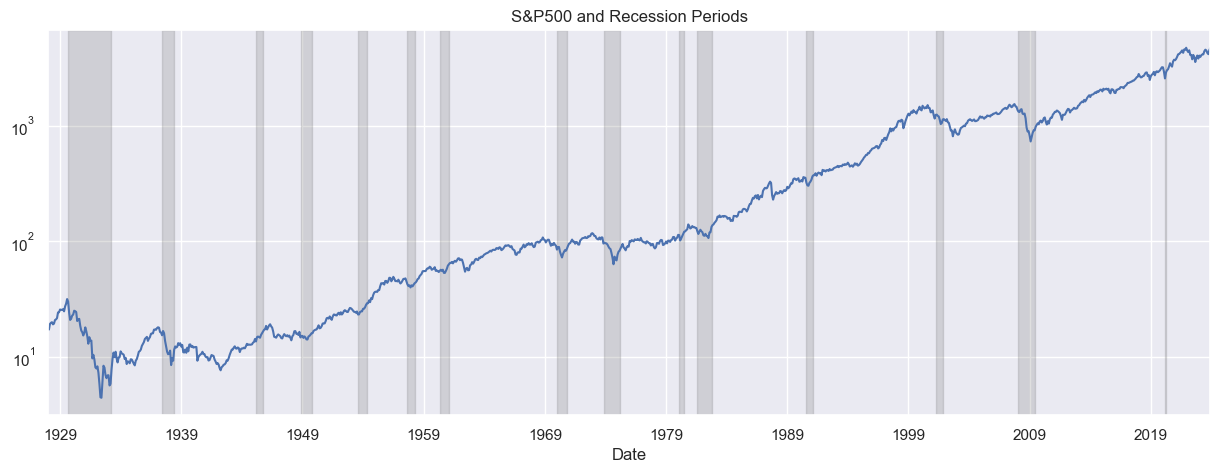

In [24]:
plt.figure(figsize=(15,5))
df_chart['S&P500'].plot(legend = False)
for i in range(len(recession_periods)):
  plt.axvspan(xmin = recession_periods[i][0], xmax = recession_periods[i][1], alpha = 0.25, color = 'grey')
plt.yscale('log')
plt.title('S&P500 and Recession Periods');

# Combine Datasets

In [25]:
df = df.merge(df_chart, left_index = True, right_index = True, how = 'left')
print(df.shape)
df.head()

(779, 171)


,RPI,W875RX1,DSPIC96,PIROA,PSAVERT,DPCERA3M086SBEA,UMCSENT,PCE,W055RC1,RETAIL,...,IPMINE,M1109BUSM293NNBR,CCUSSP01GBM650N,CCUSSP01JPM650N,CCUSSP01DEM650N,CCUSSP01CAM650N,CCUSSP01MXM650N,CCUSSP02CNM650N,S&P500,Regime
1959-01-01,2583.560,2426.0,2318.4,38.4,11.3,15.188,NaN,306.1,40.2,17583.0,...,62.6418,592.29,NaN,NaN,NaN,NaN,NaN,NaN,55.42,0.0
1959-02-01,2593.596,2434.8,2325.4,38.9,10.6,15.346,NaN,309.6,40.8,17712.0,...,63.0540,590.72,NaN,NaN,NaN,NaN,NaN,NaN,55.41,0.0
1959-03-01,2610.396,2452.7,2338.7,39.2,10.3,15.491,NaN,312.7,41.3,17860.0,...,63.1913,609.12,NaN,NaN,NaN,NaN,NaN,NaN,55.44,0.0
1959-04-01,2627.446,2470.0,2353.8,39.7,11.2,15.435,NaN,312.2,41.7,17871.0,...,65.0459,616.99,NaN,NaN,NaN,NaN,NaN,NaN,57.59,0.0
1959-05-01,2642.720,2486.4,2366.6,40.1,10.6,15.622,95.3,316.1,42.1,18011.0,...,66.4883,630.80,NaN,NaN,NaN,NaN,NaN,NaN,58.68,0.0


# Handle Missing Data

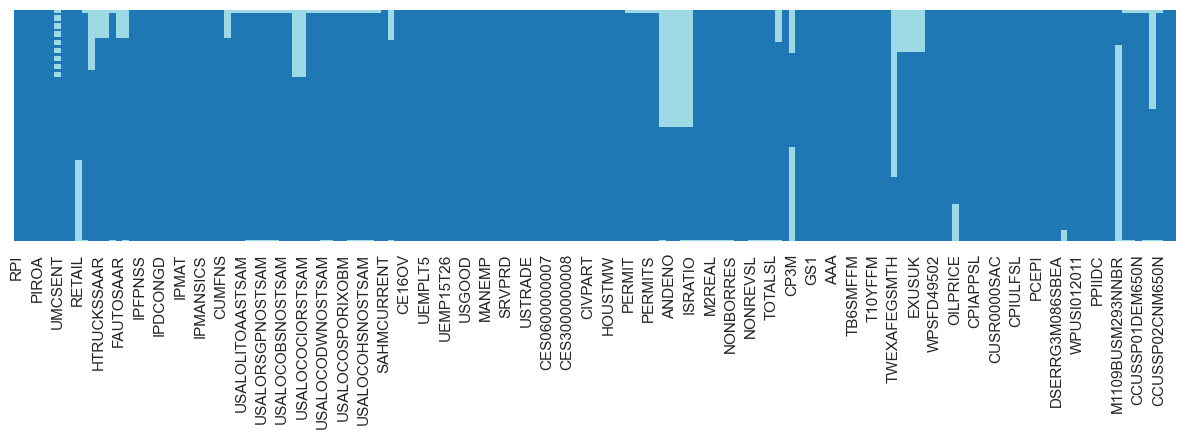

In [26]:
# visualize missing data
def check_missing_data(df):
  '''
  Visualizes missing data
  Rows with missing data are displayed in light blue
  '''
  plt.figure(figsize=(15,3))
  sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap ='tab20');

check_missing_data(df)

In [27]:
def remove_variables(df, n=10):
  '''
  Removes a variable if it has more than "n" NaN values
  Returns a dataframe without variables with NaNs
  ----------
  Parameters
  ----------
  df : dataframe
  n : number of NaN values (int)
  '''
  dropped_cols = {}
  for col in df.columns:
    nas = df[col].isna().sum()
    if nas > n:
      dropped_cols[col] = nas
      df.drop(col, axis=1, inplace=True)
  return df, dropped_cols

In [28]:
# Set start date
start_date = '1/1/1960'
df = df[df.index >= start_date ]

# Drop variables with NaNs
df, dropped = remove_variables(df, n=10)
df.shape

(767, 144)

In [29]:
df.to_csv('df_raw.csv')

In [30]:
# We will drop these variables because there are more than 10 missing data
dropped

{'UMCSENT': 144,
 'RETAIL': 271,
 'TOTALSA': 192,
 'HTRUCKSSAAR': 84,
 'DAUTOSAAR': 84,
 'FAUTOSAAR': 84,
 'CMRMTSPL': 85,
 'IPX4HTMVS': 84,
 'USALOCOCINOSTSAM': 216,
 'USALOCOCIORSTSAM': 216,
 'RECPROUSM156N': 90,
 'ACOGNO': 386,
 'ANDENO': 385,
 'AMDMUO': 384,
 'BUSINV': 385,
 'ISRATIO': 385,
 'REVOLSL': 97,
 'CP3M': 450,
 'TWEXAFEGSMTH': 552,
 'EXSZUS': 132,
 'EXJPUS': 132,
 'EXUSUK': 132,
 'EXCAUS': 132,
 'OILPRICE': 124,
 'MZMSL': 34,
 'M1109BUSM293NNBR': 659,
 'CCUSSP01MXM650N': 326}